In [62]:
# https://www.youtube.com/watch?v=WVOMGekzbWE&t=2378s
# https://www.youtube.com/watch?v=_c_x8A3mNDk&t=7s
# https://github.com/google-research/tuning_playbook
# https://keras.io/keras_tuner/
# https://alexlenail.me/NN-SVG/index.html
!pip install --upgrade pip

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" #get rid of TF log messages

!pip install numpy
import numpy as np

!pip install opencv-python
import cv2

# pandas for handling csv
!pip install pandas
import pandas as pd

from glob import glob

!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical # needed to one-hot encode labels
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger

# keras-tuner for optimizing neural network
!pip install keras-tuner
import keras_tuner as kt
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import time

from train import create_dir, load_dataset

import matplotlib.pyplot as plt


#CONFUSION MATRIX
!pip install scikit-learn
!pip install seaborn
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Current

## PREPROCESSING

In [63]:
#CURRENT
#class_names = ["zero", "one", "two", "three", "four", "five", "spock"]
class_names = ["zero", "one", "two", "three", "four", "five", "spock", "other"]

""" Paths """
dataset_path = r"C:\Users\leons\Documents\DeepLearning\DatasetForFingerCounter"
model_path = os.path.join("files", "model.keras") # is created while training

#creates blank folders
def create_dir(path):
    os.makedirs(path, exist_ok=True)

#create sorted file path lists
def load_and_preprocess_dataset(file_path):
    landmarks_file = pd.read_csv(file_path, header=0)
    
    #features = landmarks_file.drop('image', axis=1)
    features = landmarks_file.drop('filename', axis=1)
    
    #
    #features = features.drop(features.columns[range(2, len(features.columns), 3)], axis=1)
    #
    
    #labels = landmarks_file.pop('image')
    labels = landmarks_file.pop('filename')
    
    labels = [label.split('_')[2] for label in labels]

    # convert string labels to integer labels
    # class_names = ["zero", "one", "two", "three", "four", "five", "spock"]
    labels = np.array([class_names.index(label) for label in labels])

    features_array = np.array(features).reshape(-1, 21, 3)
    
    return features_array, labels


""" Seeding the environment """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory for storing files """
create_dir("files")

""" Paths """
csv_path = os.path.join("files", "data.csv") # is created while training

""" Loading the dataset """
train_landmarks_file, valid_landmarks_file, test_landmarks_file = load_dataset(dataset_path)

""" Dataset Pipeline """
batch_size = 32 #batch size can be changed to which fits best for hardware
train_features, train_labels = load_and_preprocess_dataset(r"C:\Users\leons\Documents\DeepLearning\DatasetForFingerCounter\Training_landmarks.csv")
valid_features, valid_labels = load_and_preprocess_dataset(r"C:\Users\leons\Documents\DeepLearning\DatasetForFingerCounter\Validation_landmarks.csv")
test_features, test_labels = load_and_preprocess_dataset(r"C:\Users\leons\Documents\DeepLearning\DatasetForFingerCounter\Test_landmarks.csv")

## ACTUAL MODEL

In [85]:

# hp parameter to define hyperparameters from keras tuning
def build_model(hp):  
    model = keras.Sequential()

    # input layer
    model.add(layers.Flatten(input_shape=(21, 3))) # make 1 dimensional array out of 21x3 array

    # only for simple one
    # model.add(
    #     layers.Dense( 
    #         units=1024,
    #         activation="relu"
    #     )
    # )
    
    # model.add(
    #     layers.Dense( # dense = every input neuron is connected to every next neuron
    #         units=hp.Int("units", min_value=128, max_value=1024, step=128), # tune the number of neurons
    #         #units=1024,
    #         #activation=hp.Choice("activation", ["relu", "tanh"]), # tune the activation function; relu should be best
    #         activation="relu"
    #     )
    # )

    
    #ACTUAL ONE 
    for i in range(hp.Int('num_layers', 2, 3)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=64,
                                            max_value=512,
                                            step=32),
                               activation='relu'))

    
    # tune whether to use dropout
    if hp.Boolean("dropout"):
      model.add(layers.Dropout(rate=0.2))
    #TODO

    # output layer
    model.add(layers.Dense(8, activation="softmax")) # probability of every output neuron which all add up to 1

    # tune learning rate 
    #learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    learning_rate = 1e-3 # 1e-3 = 0.001
    
    model.compile(loss="sparse_categorical_crossentropy",
                  #optimizer="adam",
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"]
    )
    
    return model



""" Model """
tuner = RandomSearch(
    hypermodel=build_model,
    objective = 'val_accuracy', 
    max_trials = 30, # total number of trials to run during search; should be as high as all combinations possible; default is 10
    executions_per_trial = 2, # number of models that should be built and fit for each trial; executions within trial have same hyperparameter values
    directory='output', # where to store search results
    overwrite = True # overwrite previous results in same directory
)

""" Training """
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True, monitor='val_loss'),
    #ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path, append=True),
    # if within 50 epochs the val_loss does not decrease, the model will stop training
    EarlyStopping(monitor='val_accuracy', mode='max', patience=25)
]


# search best hyperparameter configuration; all arguments passed to search() are also passed to model.fit() in each execution
tuner.search(
    x = train_features,
    y = train_labels,
    epochs = 400,
    batch_size = 32,
    validation_data = (valid_features, valid_labels),
    callbacks=callbacks
)

best_model = tuner.get_best_models()[0]  # Get the best model found by the tuner
best_model.build(input_shape=(21, 3))
best_model.summary()
tuner.results_summary()

    
# RETRAIN MODEL WITH WHOLE DATASET AND BEST HYPERPARAMETERS
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("----------------------------------------------------")
print("best values:")
print(best_hps.values)
print("----------------------------------------------------")
model = build_model(best_hps)

history = model.fit(
    x = train_features,
    y = train_labels,
    epochs = 400,
    batch_size = 32,
    validation_data = (valid_features, valid_labels),
    callbacks=callbacks
)


# TEST
evaluation = model.evaluate(test_features, test_labels)



Trial 30 Complete [00h 01m 22s]
val_accuracy: 0.9779411554336548

Best val_accuracy So Far: 0.9901960790157318
Total elapsed time: 00h 37m 13s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 63)                0         
                                                                 
 dense (Dense)               (None, 128)               8192      
                                                                 
 dense_1 (Dense)             (None, 224)               28896     
                                                                 
 dense_2 (Dense)             (None, 448)               100800    
                                                                 
 dropout (Dropout)           (None, 448)               0         
                                                                 
 dense_3 (Dense)             (None, 8)       

In [16]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 63)                0         
                                                                 
 dense (Dense)               (None, 288)               18432     
                                                                 
 dense_1 (Dense)             (None, 320)               92480     
                                                                 
 dense_2 (Dense)             (None, 320)               102720    
                                                                 
 dense_3 (Dense)             (None, 352)               112992    
                                                                 
 dropout (Dropout)           (None, 352)               0         
                                                                 
 dense_4 (Dense)             (None, 7)                 2

In [ ]:

# num_layers: 2
# units_0: 192
# dropout: True
# learning_rate: 0.001
# units_1: 512
# units_2: 480
# units_3: 512
# units_4: 288
# Score: 0.963350772857666


# num_layers: 4
# units_0: 288
# units_1: 320
# dropout: True
# learning_rate: 0.0001
# units_2: 320
# units_3: 352
# units_4: 416
# Score: 0.963350772857666


# with "other" class:
# num_layers: 2
# units_0: 288
# units_1: 128
# dropout: True
# learning_rate: 0.001
# units_2: 512
# units_3: 288
# Score: 0.960829496383667






# with cleaned up data 

# Trial 07 summary
# Hyperparameters:
# num_layers: 2
# units_0: 256
# units_1: 384
# dropout: True
# learning_rate: 0.001
# units_2: 352
# units_3: 256
# Score: 0.9828431308269501

# Trial 23 summary
# Hyperparameters:
# num_layers: 2
# units_0: 512
# units_1: 352
# dropout: True
# learning_rate: 0.001
# units_2: 352
# units_3: 192
# units_4: 128
# Score: 0.9828431308269501

# Trial 25 summary
# Hyperparameters:
# num_layers: 2
# units_0: 480
# units_1: 224
# dropout: True
# learning_rate: 0.001
# units_2: 480
# units_3: 128
# units_4: 480
# Score: 0.9828431308269501

# Trial 09 summary
# Hyperparameters:
# num_layers: 2
# units_0: 352
# units_1: 416
# dropout: False
# learning_rate: 0.001
# units_2: 96
# units_3: 384
# Score: 0.9803921580314636







# Trial 16 summary
# Hyperparameters:
# num_layers: 2
# units_0: 384
# units_1: 192
# dropout: True
# units_2: 480
# units_3: 416
# Score: 0.9926470518112183

# Trial 21 summary
# Hyperparameters:
# num_layers: 2
# units_0: 448
# units_1: 384
# dropout: False
# units_2: 128
# units_3: 192
# Score: 0.9926470518112183

# Trial 29 summary
# Hyperparameters:
# num_layers: 2
# units_0: 160
# units_1: 480
# dropout: True
# units_2: 320
# units_3: 352
# Score: 0.9901960492134094

# Trial 06 summary
# Hyperparameters:
# num_layers: 2
# units_0: 288
# units_1: 448
# dropout: True
# units_2: 352
# units_3: 160
# Score: 0.987745076417923

# Trial 19 summary
# Hyperparameters:
# num_layers: 3
# units_0: 160
# units_1: 480
# dropout: False
# units_2: 256
# units_3: 384
# Score: 0.9852941036224365

# Trial 03 summary
# Hyperparameters:
# num_layers: 2
# units_0: 320
# units_1: 288
# dropout: True
# units_2: 416
# units_3: 512
# Score: 0.9828431308269501


# PLOTS NEW

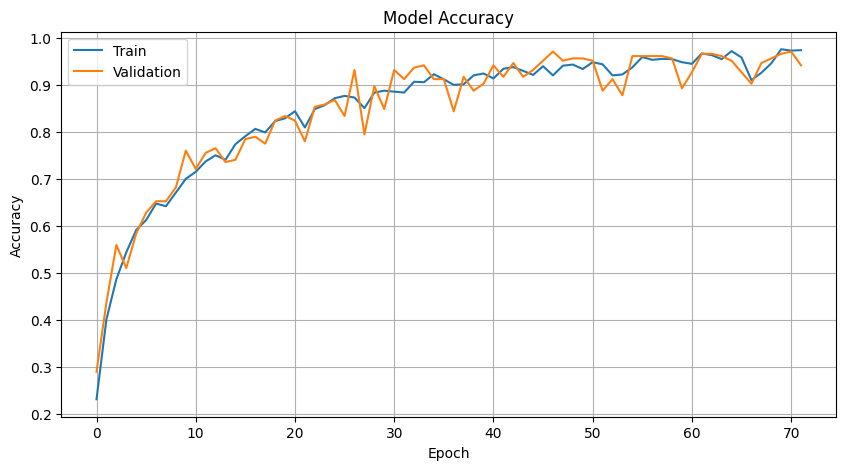

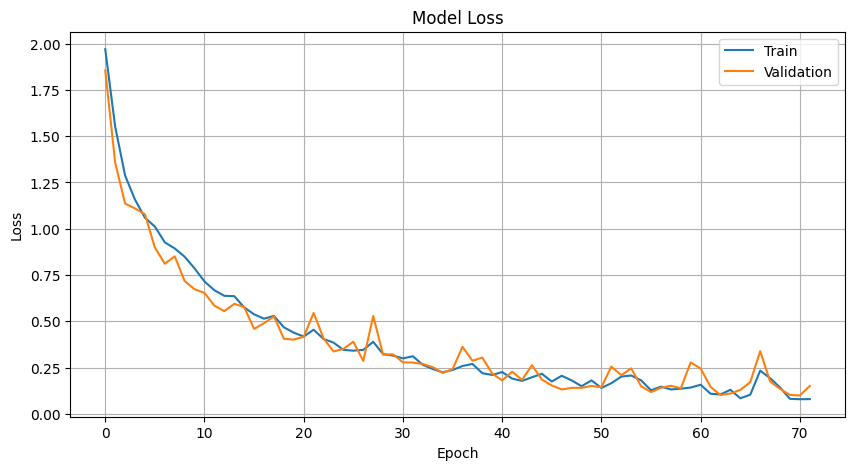

In [87]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# PLOTS OLD

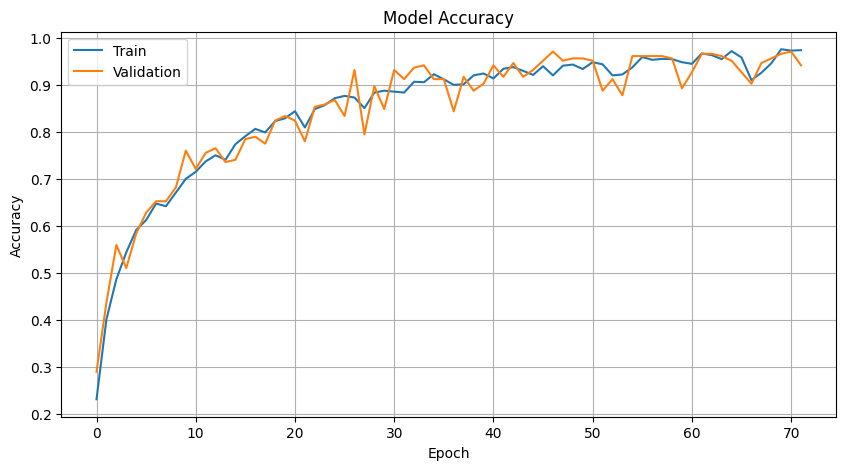

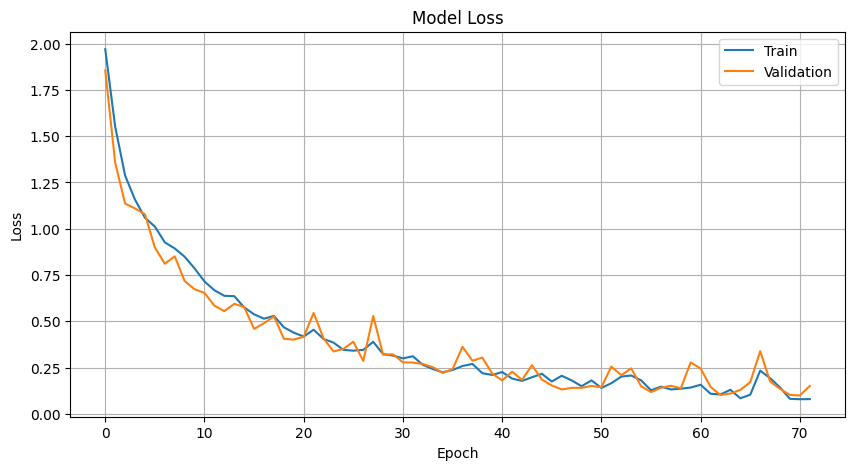

In [86]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# CONFUSION MATRIX

7/7 [==============================] - 1s 15ms/step


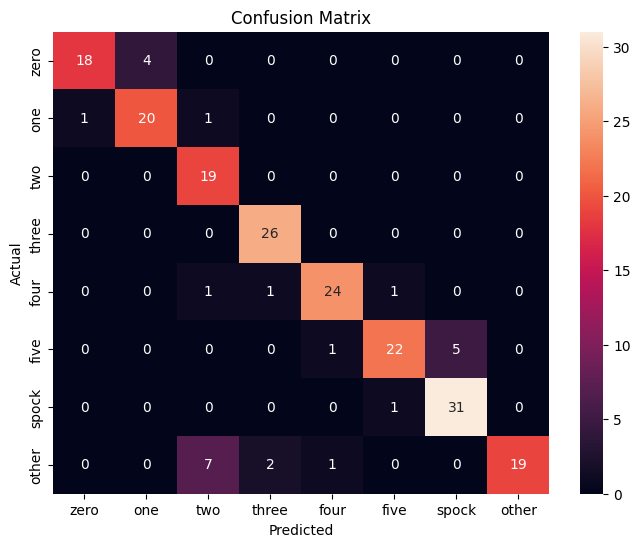

   ACTUAL LABEL PREDICTED LABEL         FILE NAME OF IMAGE
0          five           spock     Alex_image_five_64.jpg
1          five           spock     Alex_image_five_81.jpg
2          five           spock     Alex_image_five_82.jpg
3          four           three     Alex_image_four_27.jpg
4          four            five     Alex_image_four_86.jpg
5           one            zero      Alex_image_one_48.jpg
6           one             two      Alex_image_one_62.jpg
7         spock            five    Alex_image_spock_22.jpg
8          zero             one     Alex_image_zero_80.jpg
9          five           spock  Dominik_image_five_49.jpg
10         five           spock  Dominik_image_five_77.jpg
11         zero             one  Dominik_image_zero_22.jpg
12         five            four   Henrik_image_five_66.jpg
13         four             two   Henrik_image_four_33.jpg
14         zero             one   Henrik_image_zero_31.jpg
15        other             two     Leon_image_other_1.j

In [88]:
# Get predictions from the model
predictions = model.predict(test_features)
predicted_labels = np.argmax(predictions, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()




# SHOW WHICH ONES HAVE BEEN PREDICTED INCORRECTLY

incorrect_indices = np.where(test_labels != predicted_labels)[0] 
# Read the first row of the test dataset CSV file to get file names
test_file_names = pd.read_csv(r"C:\Users\leons\Documents\DeepLearning\DatasetForFingerCounter\Test_landmarks.csv", usecols=[0]).values.flatten()

# one dimensional array which contains file names of incorrect files
incorrect_files = np.array(test_file_names)[incorrect_indices] 

# Create a DataFrame for incorrectly predicted images
data = {
    'ACTUAL LABEL': [class_names[test_labels[i]] for i in incorrect_indices],
    'PREDICTED LABEL': [class_names[predicted_labels[i]] for i in incorrect_indices],
    'FILE NAME OF IMAGE': incorrect_files
}

incorrect_df = pd.DataFrame(data)

print(incorrect_df)

# DRAW LANDMARKS AND SAVE INCORRECT PREDICTED IMAGES

In [79]:
import cv2
import mediapipe as mp
import os

#needed to reconstruct landmarks from coordinates
from mediapipe.framework.formats import landmark_pb2

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils


output_folder = "wrong_images"
os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

# Path to the "Test" folder
test_folder = r"C:\Users\leons\Documents\DeepLearning\DatasetForFingerCounter\Test"
# Path to the CSV file with landmarks
csv_file = r"C:\Users\leons\Documents\DeepLearning\DatasetForFingerCounter\Test_landmarks.csv"

# Read the CSV file with landmarks
landmarks_df = pd.read_csv(csv_file, header=0)

#for file_name in incorrect_files:
for file_name, actual_label, predicted_label in zip(incorrect_files, 
                                                    incorrect_df['ACTUAL LABEL'], 
                                                    incorrect_df['PREDICTED LABEL']):
    #extract the landmarks of one image

    #extract the only the row of the current file in the csv
    specific_row = landmarks_df[landmarks_df['filename'] == file_name]
    #drop the "filename" column
    landmarks = specific_row.drop('filename', axis=1).values[0]
    #reshape into 21*3 array
    landmarks_array = np.array(landmarks).reshape(21, 3)

    #reshape the coordinates from landmarks_array into actual NormalizedLandmarks objects
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    for landmark_coords in landmarks_array:
        landmark_proto = landmark_pb2.NormalizedLandmark()
        landmark_proto.x = landmark_coords[0]
        landmark_proto.y = landmark_coords[1]
        landmark_proto.z = landmark_coords[2]
        hand_landmarks_proto.landmark.append(landmark_proto)

    #read the image
    file_path = os.path.join(test_folder, file_name)
    frame = cv2.imread(file_path)
    
    mp_drawing.draw_landmarks(frame, hand_landmarks_proto, mp_hands.HAND_CONNECTIONS,
                                      mp_drawing.DrawingSpec(color=(20, 200, 20), thickness=2, circle_radius=4),
                                      mp_drawing.DrawingSpec(color=(20, 20, 200), thickness=2, circle_radius=2))

    # Save the modified image in the output folder
    #output_file_path = os.path.join(output_folder, f"{file_name[:-4]}.jpg")
    output_file_name = f"{file_name[:-4]}pred{predicted_label}.jpg"
    output_file_path = os.path.join(output_folder, output_file_name)
    
    cv2.imwrite(output_file_path, frame)


# DRAW LANDMARKS FOR ALL IMAGES

In [56]:
import cv2
import mediapipe as mp
import os

#needed to reconstruct landmarks from coordinates
from mediapipe.framework.formats import landmark_pb2

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

images_folders = [r"C:\Users\leons\Documents\DeepLearning\DatasetForFingerCounter\Test", 
                  r"C:\Users\leons\Documents\DeepLearning\DatasetForFingerCounter\Training", 
                  r"C:\Users\leons\Documents\DeepLearning\DatasetForFingerCounter\Validation"]
csv_files = [r"C:\Users\leons\Documents\DeepLearning\DatasetForFingerCounter\Test_landmarks.csv", 
             r"C:\Users\leons\Documents\DeepLearning\DatasetForFingerCounter\Training_landmarks.csv", 
             r"C:\Users\leons\Documents\DeepLearning\DatasetForFingerCounter\Validation_landmarks.csv"]
class_names = ["zero", "one", "two", "three", "four", "five", "spock", "other"]
for name in class_names:
    
    output_folder = f"{name}_wrong_images"
    os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist
    
    for image_folder, csv_file in zip(images_folders, csv_files): 
        file_names = []
        #fill the array with all image names for current folder and cat name
        for file in os.listdir(image_folder):
            if name in file:
                file_names.append(file)
        
        landmarks_df = pd.read_csv(csv_file, header=0)

        for file_name in file_names:
            #extract the landmarks of one image
            
            #extract the only the row of the current file in the csv
            specific_row = landmarks_df[landmarks_df['filename'] == file_name]

            #read the image
            file_path = os.path.join(image_folder, file_name)
            frame = cv2.imread(file_path)
            
            if not specific_row.empty:
                
                #drop the "filename" column
                landmarks = specific_row.drop('filename', axis=1).values[0]
                #reshape into 21*3 array
                landmarks_array = np.array(landmarks).reshape(21, 3)
            
                #reshape the coordinates from landmarks_array into actual NormalizedLandmarks objects
                hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
                for landmark_coords in landmarks_array:
                    landmark_proto = landmark_pb2.NormalizedLandmark()
                    landmark_proto.x = landmark_coords[0]
                    landmark_proto.y = landmark_coords[1]
                    landmark_proto.z = landmark_coords[2]
                    hand_landmarks_proto.landmark.append(landmark_proto)
                
                mp_drawing.draw_landmarks(frame, hand_landmarks_proto, mp_hands.HAND_CONNECTIONS,
                                                  mp_drawing.DrawingSpec(color=(20, 200, 20), thickness=2, circle_radius=4),
                                                  mp_drawing.DrawingSpec(color=(20, 20, 200), thickness=2, circle_radius=2))
                
                #indent following code here > pictures with no landmarks are not processed
            # Save the modified image in the output folder
            output_file_path = os.path.join(output_folder, f"{file_name[:-4]}.jpg")
            cv2.imwrite(output_file_path, frame)


# DELETE CSV DATASETS THAT HAVE NO CORRESPONDING IMAGE

In [59]:
images_folders = [r"C:\Users\leons\Documents\DeepLearning\DatasetForFingerCounter\Test", 
                  r"C:\Users\leons\Documents\DeepLearning\DatasetForFingerCounter\Training", 
                  r"C:\Users\leons\Documents\DeepLearning\DatasetForFingerCounter\Validation"]
csv_files = [r"C:\Users\leons\Documents\DeepLearning\DatasetForFingerCounter\Test_landmarks.csv", 
             r"C:\Users\leons\Documents\DeepLearning\DatasetForFingerCounter\Training_landmarks.csv", 
             r"C:\Users\leons\Documents\DeepLearning\DatasetForFingerCounter\Validation_landmarks.csv"]

    
for image_folder, csv_file in zip(images_folders, csv_files):
        images_names = os.listdir(image_folder)
        data = pd.read_csv(csv_file, header=0)
        filtered_data = data[data['filename'].isin(images_names)]
        filtered_data.to_csv(csv_file, index=False)

# DELETE IMAGES THAT HAVE NO CORRESPONDING CSV DATASET

In [60]:
images_folders = [r"C:\Users\leons\Documents\DeepLearning\dataset_lokal\Test", 
                          r"C:\Users\leons\Documents\DeepLearning\dataset_lokal\Training", 
                          r"C:\Users\leons\Documents\DeepLearning\dataset_lokal\Validation"]
csv_files = [r"C:\Users\leons\Documents\DeepLearning\dataset_lokal\Test_landmarks.csv", 
             r"C:\Users\leons\Documents\DeepLearning\dataset_lokal\Training_landmarks.csv", 
             r"C:\Users\leons\Documents\DeepLearning\dataset_lokal\Validation_landmarks.csv"]

    
for image_folder, csv_file in zip(images_folders, csv_files):
        images_names = os.listdir(image_folder)
        data = pd.read_csv(csv_file, header=0)

        # Get the filenames present in the CSV
        csv_image_names = data['filename'].tolist()

        # Delete images not in the CSV
        for image_name in images_names:
            if image_name not in csv_image_names:
                os.remove(os.path.join(image_folder, image_name))

# PREDICTIONS

In [89]:
# PREDICTIONS

predictions = model.predict(test_features)

print("Index\tActual Label\tPredicted Label")
print("------------------------------------")
for i in range(len(predictions)):
    actual_label = class_names[np.argmax(test_labels[i])]
    predicted_label = class_names[np.argmax(predictions[i])]
    print(f"{i}\t{actual_label:<13}\t{predicted_label}")

7/7 [==============================] - 0s 5ms/step
Index	Actual Label	Predicted Label
------------------------------------
0	zero         	five
1	zero         	five
2	zero         	five
3	zero         	five
4	zero         	spock
5	zero         	spock
6	zero         	spock
7	zero         	five
8	zero         	three
9	zero         	four
10	zero         	four
11	zero         	four
12	zero         	five
13	zero         	four
14	zero         	one
15	zero         	one
16	zero         	zero
17	zero         	two
18	zero         	one
19	zero         	one
20	zero         	one
21	zero         	other
22	zero         	other
23	zero         	other
24	zero         	other
25	zero         	other
26	zero         	other
27	zero         	other
28	zero         	other
29	zero         	other
30	zero         	spock
31	zero         	spock
32	zero         	five
33	zero         	spock
34	zero         	spock
35	zero         	spock
36	zero         	spock
37	zero         	spock
38	zero         	three
39	zero       

# MY OLD

In [ ]:

def build_model():  
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(21, 3)), # make 1 dimensional array out of 21x3 array
        tf.keras.layers.Dense(128, activation='relu'), # every input neuron is connected to every next neuron
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(7, activation='softmax') # probability of every output neuron which all add up to 1
    ])

    #model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(1e-3)) # optimizer parameter is the learning rate
    #https://www.atmosera.com/blog/multiclass-classification-with-neural-networks/#:~:text=The%20output%20layer%20contains%20one,neuron%20corresponds%20to%20one%20class.
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]) # do not change
    
    return model

    
""" Model """
model = build_model()

""" Training """
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True, monitor='val_loss'),
    #ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path, append=True),
    # if within 20 epochs, the val_loss does not decrease, the model will stop training
    #EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]

# train model
model.fit(train_features,
    train_labels,
    validation_data=(valid_features, valid_labels),
    epochs=400, # can also be 100
    callbacks=callbacks
)
# train until early stop TODO 



evaluation = model.evaluate(test_features, test_labels)
